# SMA-A2 Post-processing routines

This is a set of routines to prepare the ouptputs to users of SM-A3 ForCoast service module. 

It should be executed after the preparation of Lagrangian tracks (Parcels), once per pollutant sources. 

As such, it should prepare numeric outputs specific to each sources, as well as instance of figures for each specific source. In a later stage, a 'final post-processing script' may  be considered to gather processed infromation from the different sources. 

Basically, in terms of computation the processing should : 
* Get the age distribution of particles within the box at any time step of the lagrangian simulation. 
* Keep a count of particle entering the domain within a day (or an hour)

The outputs consists in 

* Time series of proportion (#particles entering the domain / #particles released from source) reaching the farm before a given Age threshold (or several).
* Based on the above, a flag based on a probability threshold to send a warning.
* Maps of Age distribution (eg. animations) 


## Module load and Specific definition

**TODO**
* fix rules for filenames. 
* Build interface to get user-defined values from somewhere (JSON or Yaml namelists ? ) 

In [1]:
import netCDF4
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import numpy.ma as ma
from datetime import timedelta as delta
from cartopy.io import shapereader
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs

fname = 'GalwayParticles.nc'

figsuffix = 'GalwayforGA'

# To Get high res coastlines.
# https://clouds.eos.ubc.ca/~phil/courses/atsc301/coursebuild/html/hires_map.html
# To generate new shapefile for other domains : 
# ogr2ogr -skipfailures -f "ESRI Shapefile"  -clipsrc -10.0 53.0 -8.0 54.0 galway_coastlines coastlines-split-4326

coastlinefile = "./galway_coastlines/lines.shp"

# Particles release per hour (! assuming one file per source at this stage !)
ReleaseRate = 60 

# Age after which we don't care.
thres_Age = 10*24 # hours

# Time bins for post-processing
outtimestep = 12 # Hours

# Make animations or Not
BuildAnim = True

# Thresolds for alarm (should be a curve)
Age_Alarm      = 1  # Days
Fraction_Alarm = 6 # % of release

In [2]:
poly1 = [[-9.0175,53.16816958],
[-9.041166667,53.16817019],
[-9.042,53.18817033],
[-9.018833333,53.18816981]]
#poly1=None
polys=[poly1]

# To build map domains
domainpercentiles = [1,.75,.5]
expansionfactors_x  = [0.1,.2,.2]
expansionfactors_y  = [0.1,.2,.2]

# Age Classes for some outputs
agesc=[0,.3,.6,1.0,1.5,2,3]


## Functions

In [3]:
# Function to prepare axis for map plots.
def start_axes(title, extent, fig=None, sp=None, fast=False):
    if fig is None:
        fig = plt.figure(figsize=(13, 5))
        
    if sp is None:
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94],projection=ccrs.PlateCarree())
    else:
        ax = fig.add_subplot(sp,projection=ccrs.PlateCarree())
            
    ax.set_extent(extent)
    ax.gridlines()
#    ax.add_feature(NaturalEarthFeature('physical', 'ocean', '10m'))
    
    if not fast and coastlinefile is not None:
        shape_project=ccrs.PlateCarree()
        shp = shapereader.Reader(coastlinefile)
        for record, geometry in zip(shp.records(), shp.geometries()):
            ax.add_geometries([geometry], shape_project,facecolor="none",
                      edgecolor='black',lw=1)
    else:
        ax.coastlines(resolution='10m')
    #ax.set_xlim(-6, 36.5), ax.set_ylim(30, 46)
    #ax.set_aspect("equal")
    ax.set_title(title)
    ax.gridlines(xlocs=range(25,42,1), ylocs=range(40,48,1),draw_labels=True)#
    return ax

In [4]:
# Function to identify if particles are in a polygon

import matplotlib.path as mpltPath

def mplpoly(xin,yin,poly): 
    if (isinstance(xin,np.ndarray))&(len(xin.shape)>1):
        fromarray=True
        x = xin.flatten()
        y = yin.flatten()
    else:
        fromarray=False
        x=xin
        y=yin

    path = mpltPath.Path(poly)
    points=np.array([x, y]).T
    inside = path.contains_points(points)
    
    if fromarray:
        inside= np.reshape(inside, xin.shape)
    return(inside)

In [5]:
# Function to automatically set map extents

def update_extent(data_xarray):
    
    lonmax = float(data_xarray['lon'].max().values) 
    lonmin = float(data_xarray['lon'].min().values)
    latmax = float(data_xarray['lat'].max().values)
    latmin = float(data_xarray['lat'].min().values)
    lonrange =  lonmax-lonmin
    latrange =  latmax-latmin
    
    ext1  = [ lonmin - lonrange * expansionfactors_x[0],
              lonmax + lonrange * expansionfactors_x[0],
             latmin - latrange * expansionfactors_y[0],
              latmax + latrange * expansionfactors_y[0]]

    
    lonmax = float(data_xarray['lon'].quantile(domainpercentiles[1]).values) 
    print(lonmax)
    lonmin = float(data_xarray['lon'].quantile(1-domainpercentiles[1]).values)
    print(lonmin)
    latmax = float(data_xarray['lat'].quantile(domainpercentiles[1]).values)
    latmin = float(data_xarray['lat'].quantile(1-domainpercentiles[1]).values)
    lonrange =  lonmax-lonmin
    latrange =  latmax-latmin
    
    ext2  = [ lonmin - lonrange * expansionfactors_x[1],
              lonmax + lonrange * expansionfactors_x[1],
             latmin - latrange * expansionfactors_y[1],
              latmax + latrange * expansionfactors_y[1]]

    lonmax = float(data_xarray['lon'].quantile(1-domainpercentiles[2]).values) 
    lonmin = float(data_xarray['lon'].quantile(domainpercentiles[2]).values)
    latmax = float(data_xarray['lat'].quantile(1-domainpercentiles[2]).values)
    latmin = float(data_xarray['lat'].quantile(domainpercentiles[2]).values)
    lonrange =  lonmax-lonmin
    latrange =  latmax-latmin
    
    ext3  = [ lonmin - lonrange * expansionfactors_x[2],
              lonmax + lonrange * expansionfactors_x[2],
             latmin - latrange * expansionfactors_y[2],
              latmax + latrange * expansionfactors_y[2]]

    return([ext1, ext2,ext3])


In [6]:
# function to add a km scale on maps.

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

## Data Load

In [7]:
data_xarray = xr.open_dataset(fname)

In [8]:
np.set_printoptions(linewidth=160)
ns_per_hour = np.timedelta64(1, 'h') # nanoseconds in an hour

In [9]:
outputdt = delta(hours=outtimestep)
timerange = np.arange(np.nanmin(data_xarray['time'].values),
                      np.nanmax(data_xarray['time'].values)+np.timedelta64(outputdt), 
                      outputdt) # timerange in nanoseconds

# Level 2 : Time Series

Compute the number of particles entering the polygon with an age below `thres_Age`.

Save a netcdf with 
* dimensions : (time, #polygon, #release source) 
* variables : 
    * proportion of particles below age threshold entering the polygon
    * lower age (or rather percentile 5%, since te min may be too much affected by a single particle)
    
On the base of this netcdf, build a time series plot. 

## First approach

In [10]:
labels=[]
ages=[]
ninside=[]

for i,t in enumerate(timerange):
    tinds       = (data_xarray['time'] > t)  & (data_xarray['time'] <= t+np.timedelta64(outputdt))
    points_x    = data_xarray['lon'].values[tinds]
    points_y    = data_xarray['lat'].values[tinds]
    areinside   = mplpoly(points_x,points_y, poly1)
    ageofinside = data_xarray['age'].values[tinds][areinside]/86400
    # Each individual particle should be counted only once !
    bid=tinds.values.copy()
    bid[bid==True]=areinside
    ninside.append(bid.any(axis=1).sum())
    ages.append(ageofinside[~np.isnan(ageofinside)])
    labels.append(np.datetime_as_string(t, unit='D')) 

relninside = np.array(ninside)/(ReleaseRate*outtimestep)*100

<ipython-input-11-b34898d16d6d>:1: RuntimeWarning: Mean of empty slice.
  meanage=[a.mean() for a in ages]
/home/arthur/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/arthur/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/arthur/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/arthur/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/arthur/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element 

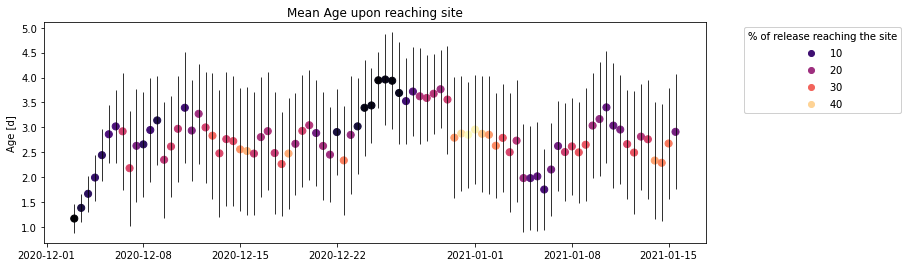

In [11]:
meanage=[a.mean() for a in ages]
sdage=[a.std() for a in ages]
meanage=ma.masked_where(relninside<0.05, meanage)
sdage=ma.masked_where(relninside<0.05, sdage)

fig = plt.figure(figsize=(10,10*0.618*0.618))
ax = fig.add_subplot(111, title='Mean Age upon reaching site')
ax.errorbar(timerange, meanage,sdage, fmt='none', color='k', lw=0.8)
scat=ax.scatter(timerange, meanage, 50,relninside, cmap='magma')
ax.set_ylabel('Age [d]')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scat.legend_elements(num=5), title="% of release reaching the site", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.add_artist(legend1)


## produce a legend with a cross section of sizes from the scatter
#handles, labels = scat.legend_elements(prop="sizes", alpha=0.6)
#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.tight_layout()
fig.savefig( figsuffix+'_TS1.png', dpi=200, bbox_extra_artists=(legend1,), bbox_inches='tight')
plt.show()

## Second Approach

In [12]:
ninsideperclass =np.zeros((len(timerange), len(agesc)-1))

for i,t in enumerate(timerange):
    tinds       = (data_xarray['time'] > t)  & (data_xarray['time'] <= t+np.timedelta64(outputdt))
    points_x    = data_xarray['lon'].values[tinds]
    points_y    = data_xarray['lat'].values[tinds]
    points_age  = data_xarray['age'].values[tinds]/86400
    
    for j in range(len(agesc)-1):
        age_id = (points_age >= agesc[j]) & (points_age < agesc[j+1])
        points_xl  = points_x[age_id]
        points_yl  = points_y[age_id]
        areinside = mplpoly(points_xl,points_yl, poly1)
        # Each individual particle should be counted only once !
        bid=tinds.values.copy()
        bid2 = age_id.copy()
        bid2[bid2==True]=areinside             
        bid[bid==True]=bid2
        ninsideperclass[i,j]=bid.any(axis=1).sum()
        #ages.append(ageofinside)
        
relninsideperclass = ninsideperclass/(ReleaseRate*outtimestep)*100

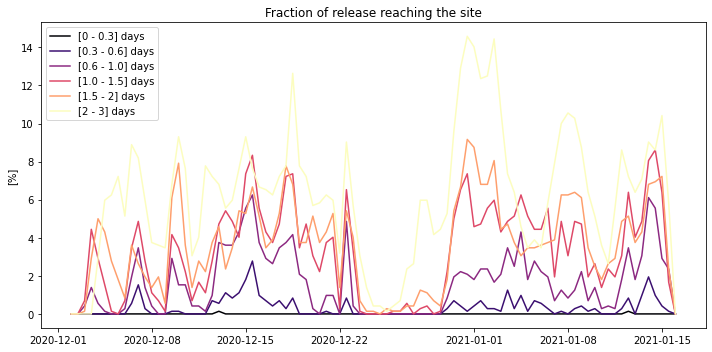

In [13]:
plt.close()

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.set_prop_cycle('color',[plt.cm.magma(i) for i in np.linspace(0, 1, len(agesc)-1)])

for j in range(len(agesc)-1):
    ax.plot(timerange, relninsideperclass[:,j], label = "["+ str(agesc[j])+' - ' + str(agesc[j+1])+'] days')

ax.legend()    
ax.set_title('Fraction of release reaching the site')
ax.set_ylabel('[%]')

plt.tight_layout()
fig.savefig( figsuffix+'_TS2.png', dpi=200, bbox_extra_artists=(legend1,), bbox_inches='tight')
plt.show()

# Level 1 : Alarm

In [14]:
alarmtab =  [ [(agesc[j+1] <= Age_Alarm) and (relninsideperclass)>Fraction_Alarm ]
             for j in range(len(agesc)-1) for i,t in enumerate(timerange) ]

criticalages = (np.array(agesc)<=Age_Alarm)[:-1]

alarmtab = [t for i,t in enumerate(timerange) if (relninsideperclass[i,criticalages]>Fraction_Alarm).any()]
antialarmtab = [t for i,t in enumerate(timerange) if (relninsideperclass[i,criticalages]<.2).all()]

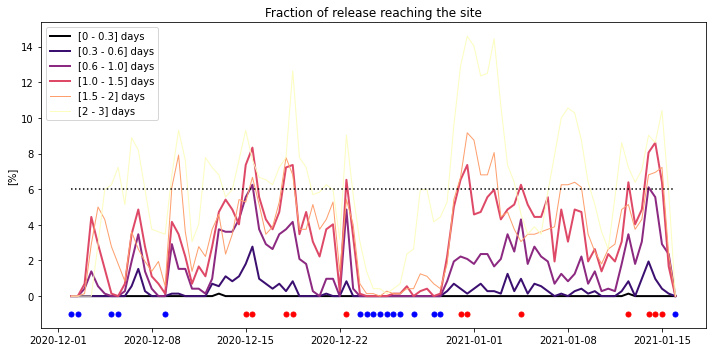

In [15]:
plt.close()

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.set_prop_cycle('color',[plt.cm.magma(i) for i in np.linspace(0, 1, len(agesc)-1)])

for j in range(len(agesc)-1):
    if agesc[j]<=Age_Alarm:
        lw=2
    else:
        lw=1        
        
    ax.plot(timerange, relninsideperclass[:,j], lw=lw, label = "["+ str(agesc[j])+' - ' + str(agesc[j+1])+'] days')

ax.plot(timerange, np.ones(len(timerange))*Fraction_Alarm, color='black', linestyle='dotted')
ax.scatter(alarmtab, np.zeros(len(alarmtab))-1, 25,'red')
ax.scatter(antialarmtab, np.zeros(len(antialarmtab))-1, 25,'blue')

ax.legend()    
ax.set_title('Fraction of release reaching the site')
ax.set_ylabel('[%]')

plt.tight_layout()
fig.savefig( figsuffix+'_TS_Alarm.png', dpi=200, bbox_extra_artists=(legend1,), bbox_inches='tight')
plt.show()

## Maps

In [16]:
if len(alarmtab)> 20: 
    raise SystemExit("You probably have too much alarms, revise Alarm parameters!")

Maps built for date with Alarm thresolds passed. 

In [17]:
exts = update_extent(data_xarray)

-8.937768271672772
-9.044289833342704


<ipython-input-6-c9bf1521dd76>:17: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


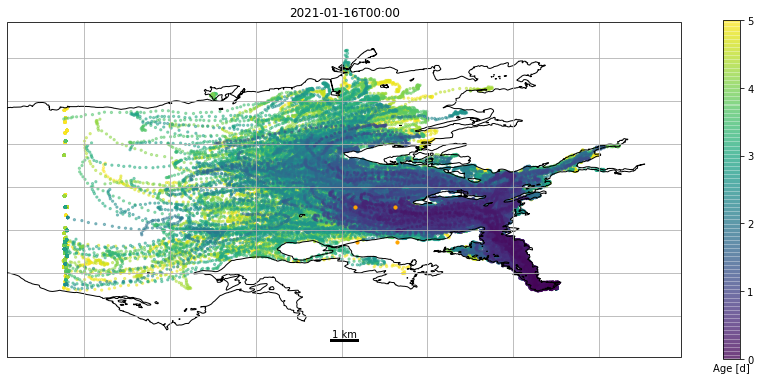

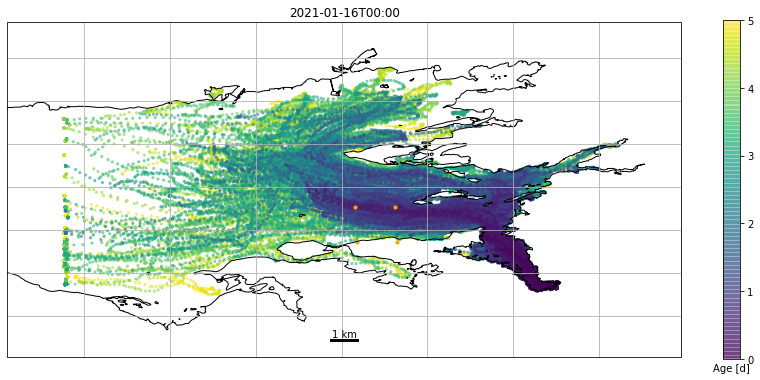

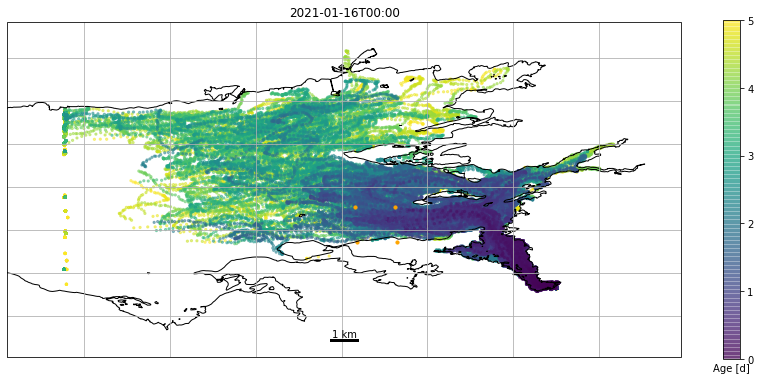

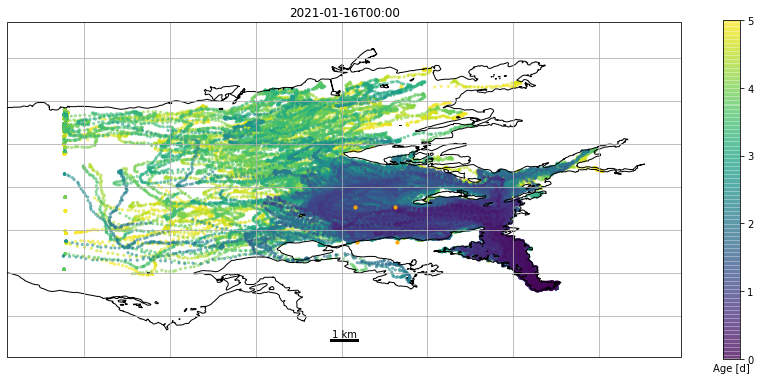

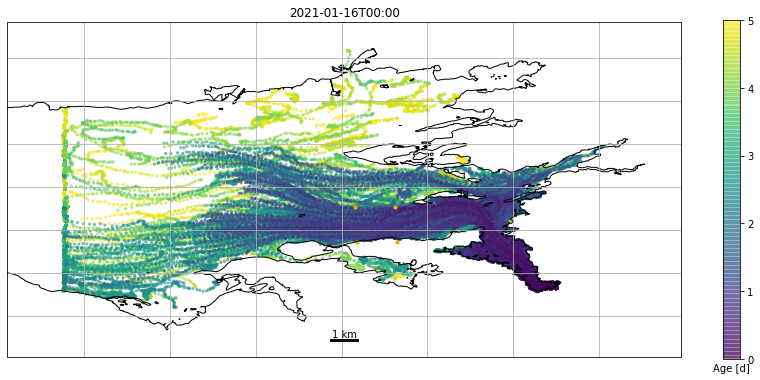

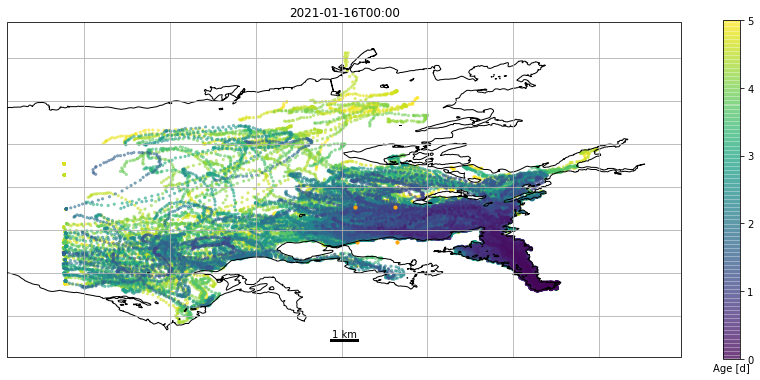

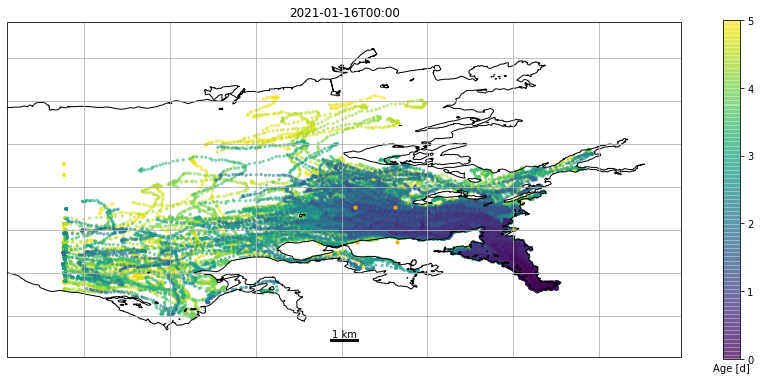

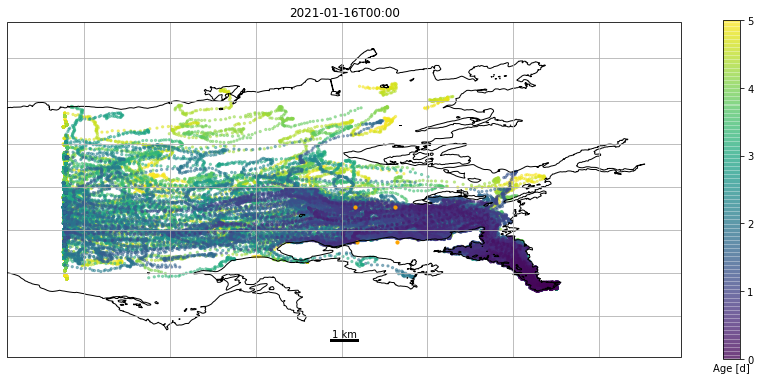

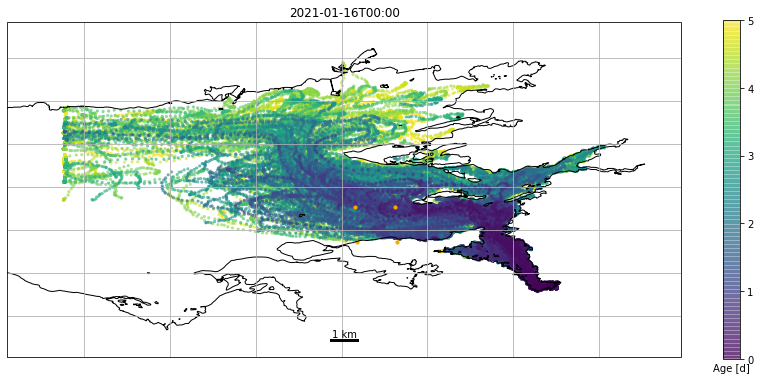

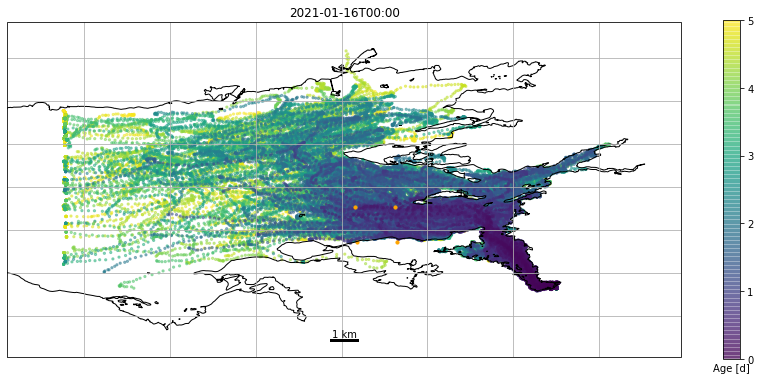

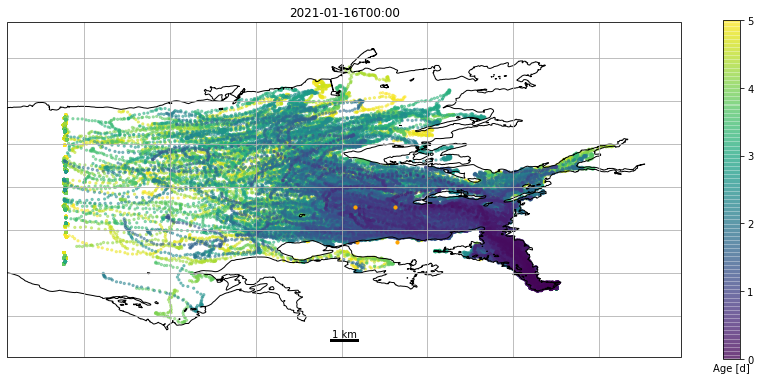

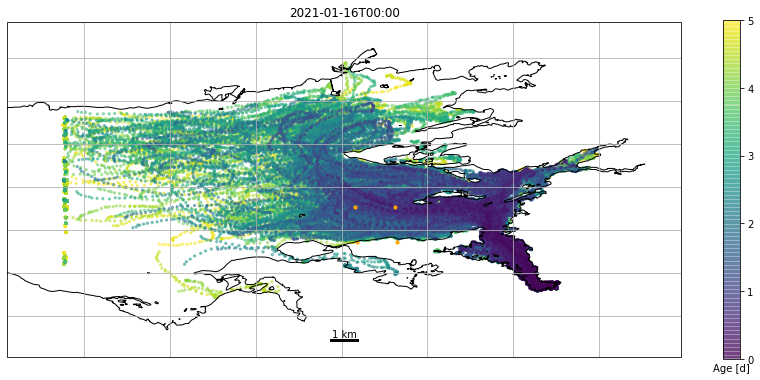

In [18]:
axs = []
scats=[]
scatpolys=[]

for ti,t in enumerate(alarmtab) : 
    ax1   = start_axes(title='Map1', extent=exts[0])
    tinds = (data_xarray['time'] > t)  & (data_xarray['time'] <= t+np.timedelta64(outputdt))
    sc1= ax1.scatter(data_xarray['lon'].values[tinds],
                     data_xarray['lat'].values[tinds], 5,
                     data_xarray['age'].values[tinds]/86400, vmin=0,vmax=5, alpha=.5)
    if polys[0] is not None:
        scatpolys.append(ax1.scatter(np.array(poly1)[:,0],np.array(poly1)[:,1],10,'orange' ))
    clb =plt.colorbar(sc1)
    clb.ax.set_xlabel('Age [d]')
    ax1.set_title( np.datetime_as_string(timerange[i], unit='m'))
    scale_bar(ax1, 1)
    plt.savefig('AllTracks_Alarm'+str(ti)+'.png')

<ipython-input-6-c9bf1521dd76>:17: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


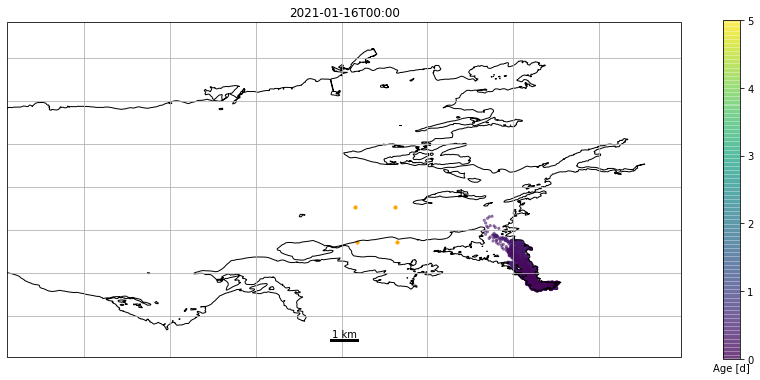

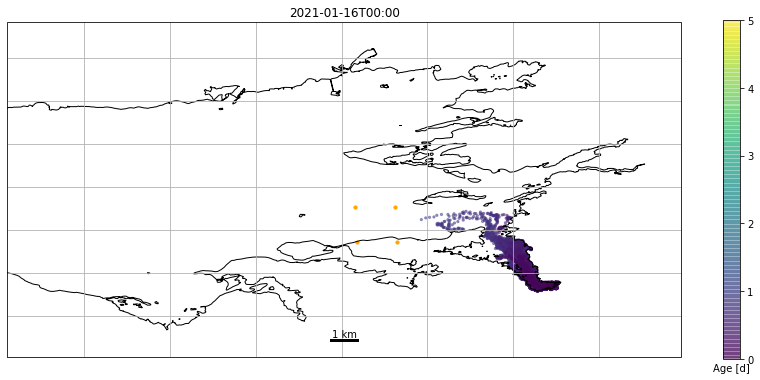

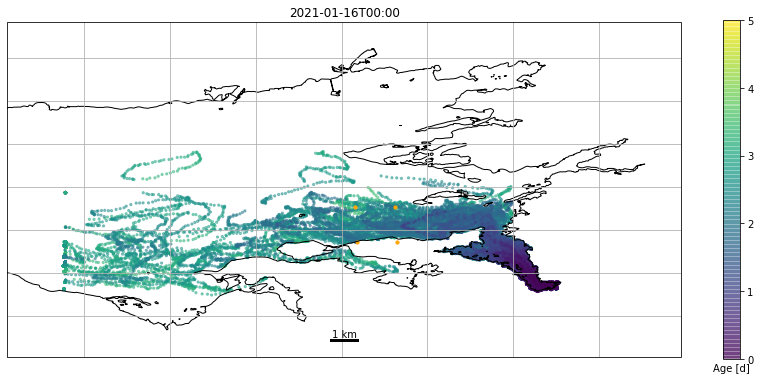

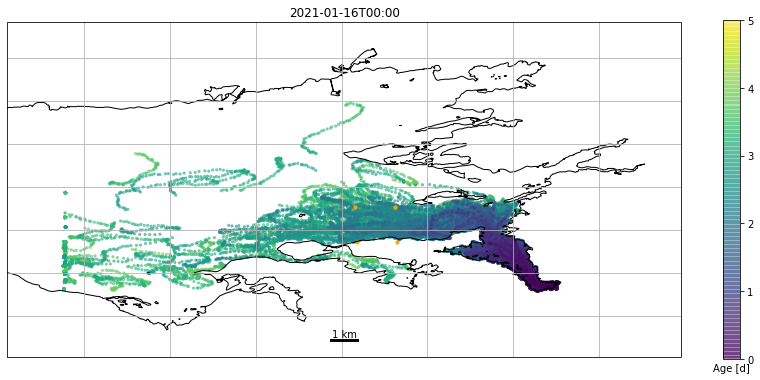

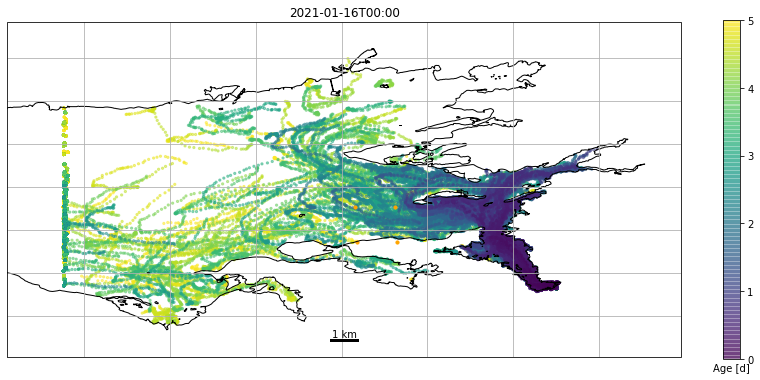

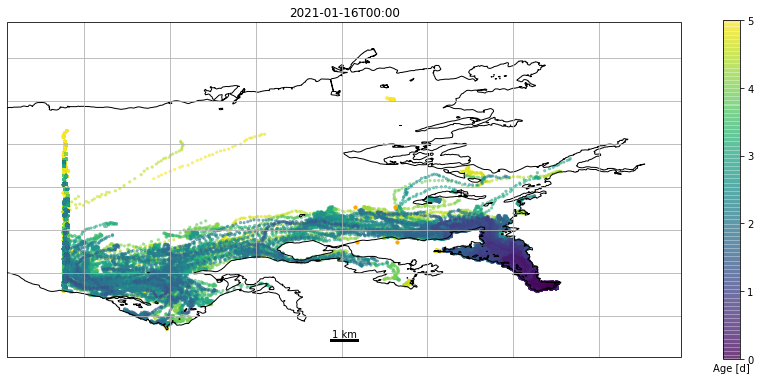

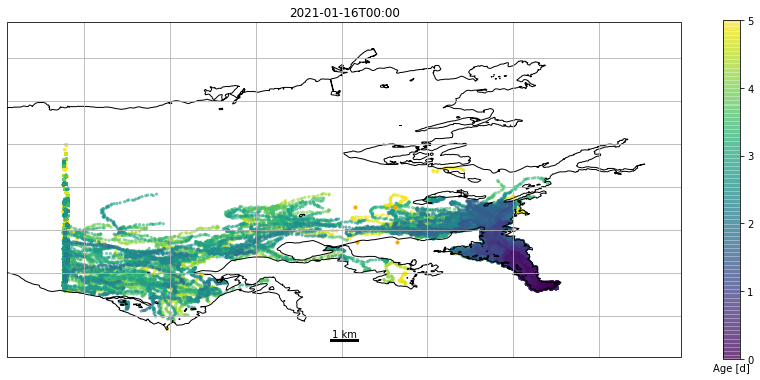

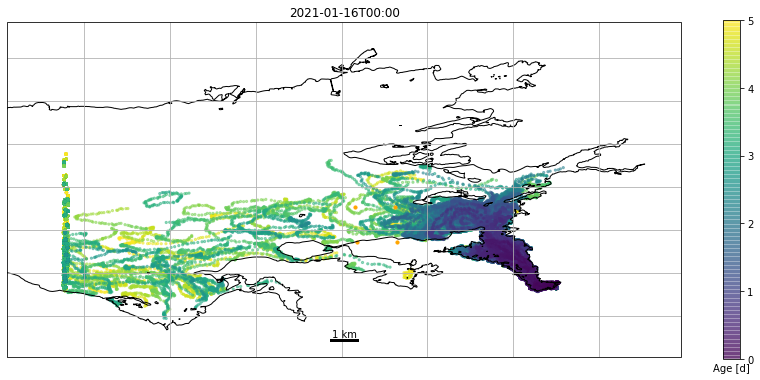

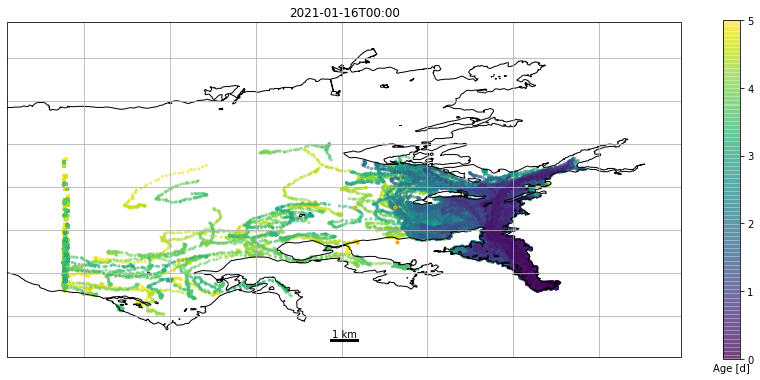

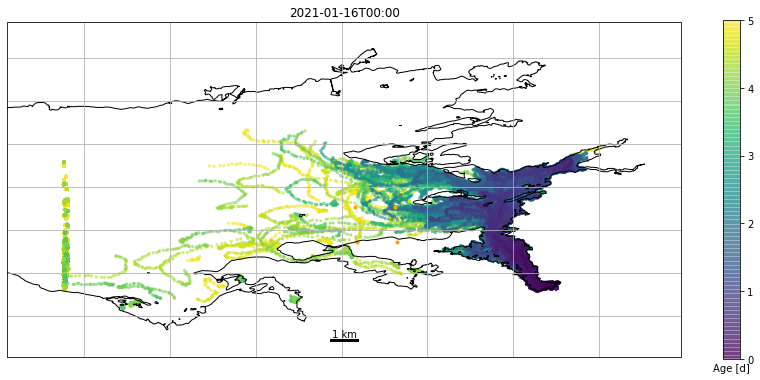

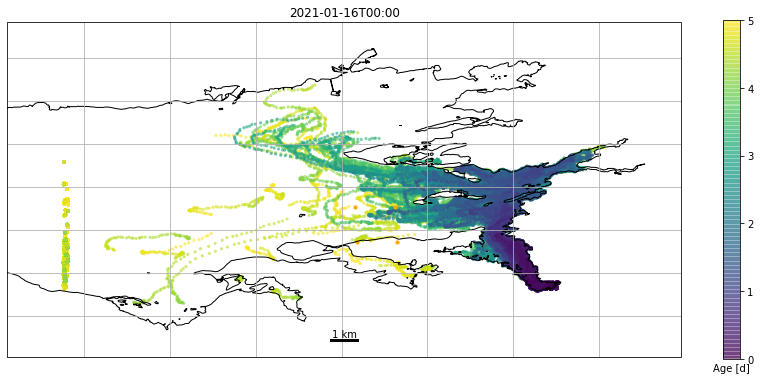

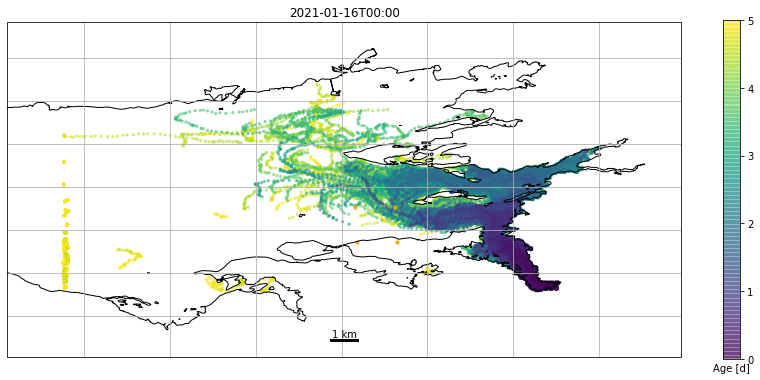

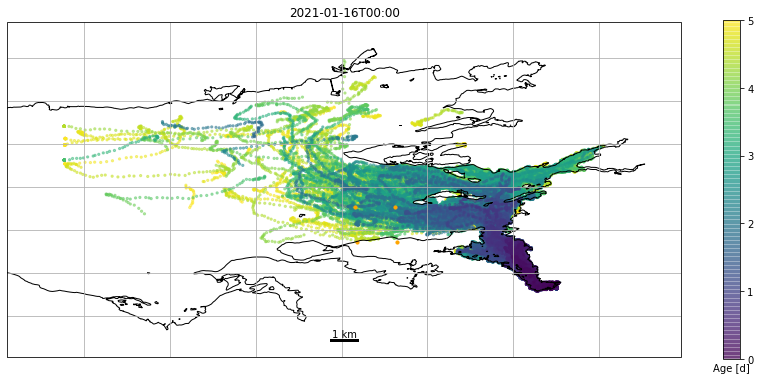

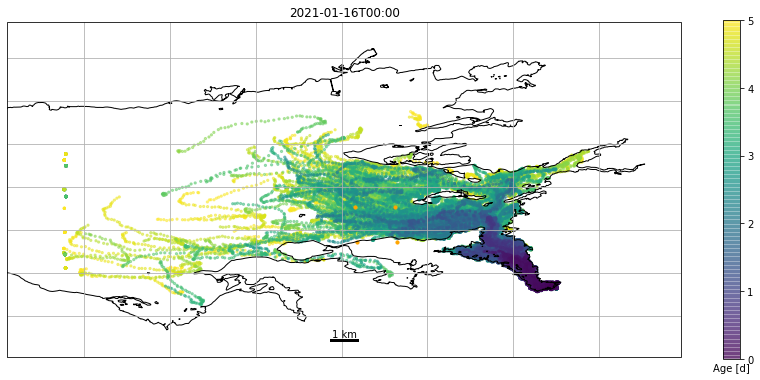

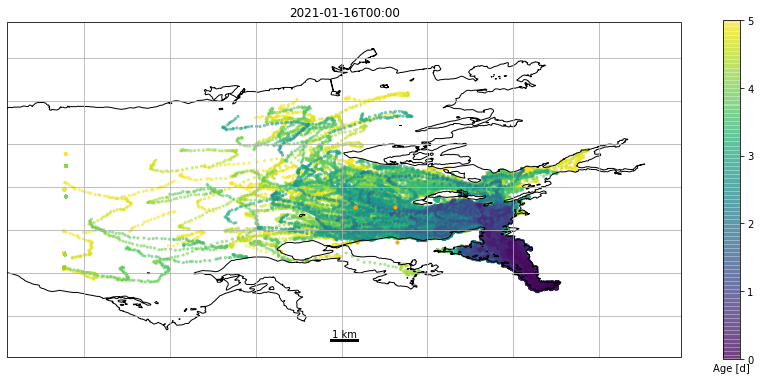

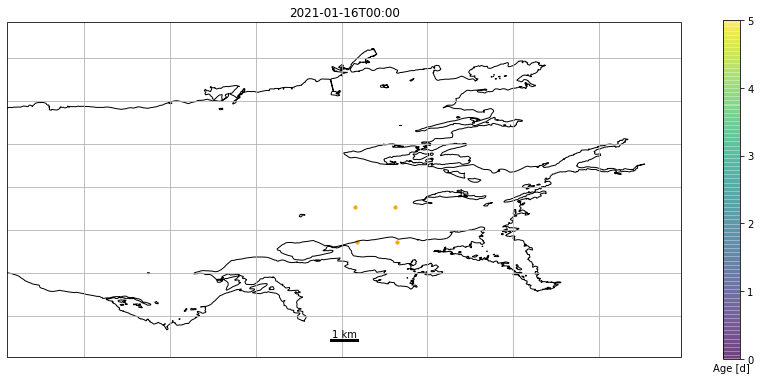

In [19]:
axs = []
scats=[]
scatpolys=[]

for ti,t in enumerate(antialarmtab) : 
    ax1   = start_axes(title='Map1', extent=exts[0])
    tinds = (data_xarray['time'] > t)  & (data_xarray['time'] <= t+np.timedelta64(outputdt))
    sc1= ax1.scatter(data_xarray['lon'].values[tinds],
                     data_xarray['lat'].values[tinds], 5,
                     data_xarray['age'].values[tinds]/86400, vmin=0,vmax=5, alpha=.5)
    if polys[0] is not None:
        scatpolys.append(ax1.scatter(np.array(poly1)[:,0],np.array(poly1)[:,1],10,'orange' ))
    clb =plt.colorbar(sc1)
    clb.ax.set_xlabel('Age [d]')
    ax1.set_title( np.datetime_as_string(timerange[i], unit='m'))
    scale_bar(ax1, 1)
    plt.savefig('AllTracks_AntiAlarm'+str(ti)+'.png')

## Level 3

Gif animation.

To be refined ... 

In [20]:
if not BuildAnim: 
    raise SystemExit("You choosed to skip the animation.")

In [21]:
if polys[0] is not None:
    apoly1=np.array(poly1)
    ml=np.min(apoly1[:,1])
    Ml=np.max(apoly1[:,1])
    mL=np.min(apoly1[:,0])
    ML=np.max(apoly1[:,0])
    extp=[mL-(ML-mL), ML+(ML-mL), ml-(Ml-ml), Ml+(Ml-ml)]

In [22]:
from matplotlib.animation import FuncAnimation

#exts=exts[0:1]

# %%capture
fig = plt.figure(figsize=(15,5))

nexts=len(exts)


axs = []
scats=[]
scatpolys=[]

time_id = np.where(data_xarray['time'] == timerange[0]) # Indices of the data where time = 0

for i,ext in enumerate(exts):     
    axs.append(start_axes('Zoom', fig=fig,sp=int('1'+str(nexts)+str(i+1)), extent=ext))
    

    scats.append( axs[i].scatter(data_xarray['lon'].values[time_id],
                              data_xarray['lat'].values[time_id],10,
                              data_xarray['age'].values[time_id]/86400, vmin=0,vmax=5))
    if polys[0] is not None:
        scatpolys.append(axs[i].scatter(np.array(poly1)[:,0],np.array(poly1)[:,1] ))

clb3 =plt.colorbar(scats[i])
clb3.ax.set_xlabel('Age [d]')

t = np.datetime_as_string(timerange[0], unit='m')
title = axs[0].set_title('Particles at t = '+t)

def animate(i):
    t = np.datetime_as_string(timerange[i], unit='m')
    title.set_text('Particles at t = '+t)
    
    time_id = np.where((data_xarray['time'] >= timerange[i]) & (data_xarray['time'] < timerange[i+1]))
    
    
    for i,ext in enumerate(exts):  
        scats[i].set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
        scats[i].set_array(data_xarray['age'][time_id]/86400)
    
anim = FuncAnimation(fig, animate, frames = len(timerange)-1, interval=500)


/home/arthur/.pyenv/versions/3.8.3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:834: UserWarning: Attempting to set identical left == right == -8.965782125828937 results in singular transformations; automatically expanding.
  self.set_xlim([x1, x2])
/home/arthur/.pyenv/versions/3.8.3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:835: UserWarning: Attempting to set identical bottom == top == 53.17174196286574 results in singular transformations; automatically expanding.
  self.set_ylim([y1, y2])


ValueError: Collections can only map rank 1 arrays

<Figure size 1080x360 with 4 Axes>

In [23]:
if BuildAnim:
    from IPython.display import HTML
    HTML(anim.to_jshtml())
    anim.save('GAL1.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

ValueError: Collections can only map rank 1 arrays

### Map for Age Classes

In [ ]:
from netCDF4 import Dataset

with Dataset('./galway_bay_2020121600.nc','r') as nc:
    mask=nc.variables['mask_rho'][:]
    mask_lon=nc.variables['lon_rho'][:]
    mask_lat=nc.variables['lat_rho'][:]


In [ ]:
ext=exts[0]
plot_type='contours'


In [ ]:
if plot_type=='contours':
    import scipy.stats as st
    from scipy import interpolate
    # Grid for Kernel Estimation
    xmin = ext[0] ; xmax = ext[1] ; ymin = ext[2] ; ymax = ext[3] 
    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]   
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # Build landmask on kernel grid    
    interpolator = interpolate.RectBivariateSpline( mask_lat[:,0], mask_lon[0][None,:],mask)
    maskonsubgrid = interpolator( yy[0], xx[:,0])

In [ ]:
fig = plt.figure(figsize=(20,15))
axs = []

for i in range(len(agesc)-1) :
    age_id = np.where((data_xarray['age']/86400 >= agesc[i] ) & 
                      (data_xarray['age']/86400 < agesc[i+1] )&
                      (data_xarray['lon'] > xmin) &
                      (data_xarray['lon'] < xmax) & 
                      (data_xarray['lat'] > ymin) &
                      (data_xarray['lat'] < ymax) )

    axs.append(start_axes(title='Particles with Age in ['+ str(agesc[i])+' - ' + str(agesc[i+1])+'] days ',
                          fig=fig,sp=int(str(int(np.ceil(len(agesc)/2)))+'2'+str(i+1)), extent=ext))

    x= data_xarray['lon'].values[age_id]
    y= data_xarray['lat'].values[age_id]
    if plot_type != "contours": 
        sc= axs[i].scatter(x,y,10,
                              data_xarray['age'][age_id]/86400, vmin=0, vmax=np.max(agesc))
        clb =plt.colorbar(sc)
        clb.ax.set_xlabel('Age [d]')


    else:
        # Peform the kernel density estimateab

        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        #sc = axs[i].contourf(xx, yy, f, cmap='Blues')
        ## Or kernel density estimate plot instead of the contourf plotab
        #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
        # Contour plot
        print(" Kernel Integral ")
        print(kernel.integrate_box([xmin,ymin],[xmax,ymax]))
        print(f.sum())
        print(" Kernel Half Integral ")
        print(kernel.integrate_box([xmin,ymin],[xmax - (xmax-xmin)/2,ymax]))

        f=f/f.max()
        f=ma.masked_where(maskonsubgrid.T.round()==0, f)
        cset = axs[i].contourf(xx, yy, f,  cmap='Blues',levels = np.array([.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]))
#        ax.clabel(cset, inline=1, fontsize=10, colors='k')
#        sc= axs[i].scatter(x,y, color='k')
        clb =plt.colorbar(cset)
        clb.ax.set_xlabel('Relative Dist')
    
    print(" Mean Age ")
    print(data_xarray['age'][age_id].mean()/86400)
    print("  ---  "+ str(agesc[i])+' - ' + str(agesc[i+1]))


    scale_bar(axs[i], 1)
    
fig.savefig('Galway_KDE_2.png')
